# ei_selection.ipynb
This notebook is used to create a balanced network of excitatory and inhibitory units that become selective
for particular input patterns. It has the same network as ei_selective.ipynb, but in here most things are 
encapsulated within the selection class.

By Sergio Verduzco Flores        August 2017

The cells below:
* Create two NxN layers, one excitatory, and one inhibitory.
* Connect the layers with center-excitation surround-inhibition connectivity. E-E connections use
  Hebbian learning with substractive normalization, I-E connections use homeostatic inhibition,
  similar to Moldakarimov06 (in ei_net.ipynb).
* Create an input layer where the activity of each unit is a function of the current input pattern.
* Connects the input layer to E,I layers using a connection pattern based on a Gaussian kernel, and
  using BCM synapses.
* Runs a simulation where input patterns are randomly selected and presented sequentially, similarly
  to the way this was done in the test3,4,5 notebooks.
  
The experiment consists of finding whether selectivity to patterns will arise in the units.
- - -


In [1]:
%cd ..
from draculab import *
from matplotlib import pyplot as plt
import numpy as np
import time
from mpl_toolkits.axes_grid1 import ImageGrid

/home/z/projects/draculab


In [2]:
class parameters():
    """
        Instances of this class contain all the parameters used by the 'selection' class.
        
        All parameters derived from other parameters will be recalculated in 
        selection.__init__ . They're here too for readability.
    """
    def __init__(self):
        ########################## Here be all parameters
        # NETWORK PARAMETERS 
        self.md = 0.1 # minimum delay in the network
        self.min_buff_size = 5 # minimum buffer size
        self.rtol = 1e-4 # relative tolerance of the ODE solver
        self.atol = 1e-4 # absolute tolerance of the ODE solver
        self.N = 5 # The network's layers will have size NxN
        N = self.N # for brevity
        self.L = N/2. + 2./N # side length of rectangle with the square grids.
        L = self.L
        
        # EXCITATORY UNIT PARAMETERS
        self.exc_tau = np.random.uniform(2., 3.5, N*N)   # time constants
        self.exc_init_val = np.random.uniform(0.1, 0.6, N*N)  # initial activations (around IE_des_act)
        self.exc_tau_fast = 0.2  # time constant of the fast low-pass filter
        self.exc_tau_slow = 20.  # time constant of the slow low-pass filter (for BCM)
        self.fe_thr = 0.3 # threshold of the f-I curve
        self.fe_eps = 0.2 # epsilon parameter of the f-I curve
        # geometrical arrangement of the excitatory units
        self.exc_shape = 'sheet'
        self.exc_extent = [L, L]
        self.exc_arrangement = 'grid'
        self.exc_rows = N
        self.exc_columns = N
        self.exc_center = [0., 0.]
        
        # INHIBITORY UNIT PARAMETERS
        self.inh_tau = np.random.uniform(2.5, 4., N*N)   # time constants
        self.inh_init_val = np.random.uniform(0.1, 0.6, N*N)  # initial activations
        self.inh_tau_fast = 0.2  # time constant of the fast low-pass filter
        self.inh_tau_slow = 20.  # time constant of the slow low-pass filter (for BCM)
        self.fi_thr = 0.4 # threshold of the f-I curve
        self.fi_eps = 0.2 # epsilon parameter of the f-I curve
        # geometrical arrangement of the inhibitory units
        self.inh_shape = 'sheet'
        self.inh_extent = [L, L]
        self.inh_arrangement = 'grid'
        self.inh_rows = N
        self.inh_columns = N
        self.inh_center = [0., 0.]
        
        # INPUT UNIT PARAMETERS
        self.inp_init_val = 0.2 # initial activation
        self.inp_tau_fast = 0.2 # time constant of the fast low-pass filter
        # geometrical arrangement of the input units
        self.inp_shape = 'sheet'
        self.inp_extent = [L, L]
        self.inp_arrangement = 'grid'
        self.inp_rows = N
        self.inp_columns = N
        self.inp_center = [0., 0.]
        
        # E-I CONNECTIONS
        self.EI_connection_type = 'convergent'
        self.EI_mask = {'annular':{'inner_radius' : 1.1, 'outer_radius':4.1}}
        self.EI_kernel = {'linear' : {'c' : 1., 'a' : 0.2}}
        self.EI_delays = {'linear' : {'c' : self.md, 'a' : 0.3}}
        self.EI_weights = {'uniform' : {'low' : 0.5, 'high' : 0.8}}
        self.EI_edge_wrap = True
        self.EI_boundary = {'center' : [0.,0.], 'extent' : [L, L]}
        self.EI_type = synapse_types.static
        
        # E-E CONNECTIONS
        self.EE_connection_type = 'divergent'
        self.EE_mask = {'circular':{'radius':2.}}
        self.EE_kernel = {'gaussian' : {'p_center' : 1., 'sigma' : 1.}}
        self.EE_delays = {'linear' : {'c' : self.md, 'a' : 0.3}}
        self.EE_weights =  {'uniform' : {'low' : 0.1, 'high' : 0.6}}
        self.EE_edge_wrap = True
        self.EE_boundary = {'center' : [0.,0.], 'extent' : [L, L]}
        self.EE_type = synapse_types.sq_hebbsnorm 
        self.EE_lrate = 1./200. # learning rate
        self.EE_omega = 2.5  # sum of squared EE weights 
        
        # I-E CONNECTIONS
        self.IE_connection_type = 'divergent'
        self.IE_mask = {'circular':{'radius':2.}}
        self.IE_kernel = {'gaussian' : {'p_center' : 1.4, 'sigma' : 1.}}
        self.IE_delays = {'linear' : {'c' : self.md, 'a' : 0.3}}
        self.IE_weights =  {'uniform' : {'low' : -0.6, 'high' : -0.1}}
        self.IE_edge_wrap = True
        self.IE_boundary = {'center' : [0.,0.], 'extent' : [L, L]}
        self.IE_type = synapse_types.homeo_inh
        self.IE_lrate = 1./100. 
        self.IE_des_act = 0.3
        
        # INP_EXC CONNECTIONS
        self.PE_connection_type = 'divergent'
        self.PE_mask = {'circular':{'radius':3.5}}
        self.PE_kernel = 0.6
        self.PE_delays = {'linear' : {'c' : self.md, 'a' : 0.3}}
        self.PE_weights = {'uniform' : {'low' : 0.3, 'high' : 0.5}}
        self.PE_edge_wrap = True
        self.PE_boundary = {'center' : [0.,0.], 'extent' : [L, L]}
        self.PE_type = synapse_types.bcm
        self.PE_lrate = 1./200.
        
        # INP_INH CONNECTIONS
        self.PI_connection_type = 'divergent'
        self.PI_mask = {'circular':{'radius':3.5}}
        self.PI_kernel = 0.6
        self.PI_delays = {'linear' : {'c' : self.md, 'a' : 0.3}}
        self.PI_weights = {'uniform' : {'low' : 0.3, 'high' : 0.5}}
        self.PI_edge_wrap = True
        self.PI_boundary = {'center' : [0.,0.], 'extent' : [L, L]}
        self.PI_type = synapse_types.bcm
        self.PI_lrate = 1./200.
        
        # PATTERN PRESENTATION
        self.t_pat = 20. # time each pattern will be presented
        self.t_trans = 5. # length of transition period between patterns
        self.c = 1./self.t_trans # auxiliary variable for make_fun2
        self.pat_type = 'lines' # see selection.build()
        

In [3]:
class selection():
    def __init__(self, p):
        """ Initialize parameter dictionaries using the parameter object p. """
        # optionally, seed the random number generator
        #np.random.seed(54321)
        
        ########################## Initialize derived parameters
        N = p.N; # N is used often. Might as well make a local copy.
        p.L = N/2. + 2./N # side length of the square unit grids   
        L = p.L
        p.exc_tau = np.random.uniform(2., 3.5, N*N)   # time constants
        p.exc_init_val = np.random.uniform(0., 0.6, N*N)  # initial activations
        p.exc_extent = [L, L]
        p.exc_rows = N
        p.exc_columns = N
        p.inh_tau = np.random.uniform(2.5, 4., N*N)   # time constants
        p.inh_init_val = np.random.uniform(0., 0.6, N*N)  # initial activations
        p.inh_extent = [L, L]
        p.inh_rows = N
        p.inh_columns = N
        p.inp_extent = [L, L]
        p.inp_rows = N
        p.inp_columns = N
        p.EI_boundary = {'center' : [0.,0.], 'extent' : [L, L]}
        p.EI_delays['linear']['c'] = p.md
        p.EE_boundary = {'center' : [0.,0.], 'extent' : [L, L]}
        p.EE_delays['linear']['c'] = p.md
        p.IE_boundary = {'center' : [0.,0.], 'extent' : [L, L]}
        p.IE_delays['linear']['c'] = p.md
        p.PE_boundary = {'center' : [0.,0.], 'extent' : [L, L]}
        p.PE_delays['linear']['c'] = p.md
        p.PI_boundary = {'center' : [0.,0.], 'extent' : [L, L]}
        p.PI_delays['linear']['c'] = p.md
        # stuff used to create input functions
        self.t_trans = p.t_trans
        self.c = 1./self.t_trans # auxiliary variable for make_fun2
        self.t_pat = p.t_pat
        self.params = p
        
        ########################## Initialize all the parameter dictionaries 
        self.net_params = {'min_delay' : p.md, 
                           'min_buff_size' : p.min_buff_size, 
                           'rtol':p.rtol, 
                           'atol':p.atol } 
        self.exc_params = {'tau' : p.exc_tau,
                           'function' : self.make_fe(p.fe_thr, p.fe_eps), 
                           'type' : unit_types.custom_fi, 
                           'init_val' : p.exc_init_val, 
                           'tau_fast' : p.exc_tau_fast, 
                           'tau_slow' : p.exc_tau_slow } # tau_slow vs lrate controls stability of BCM
        self.exc_geom = {'shape' : p.exc_shape, 
                         'extent' : p.exc_extent, 
                         'arrangement' : p.exc_arrangement, 
                         'rows' : p.exc_rows, 
                         'columns' : p.exc_columns, 
                         'center' : p.exc_center }
        self.inh_params = {'tau' :p.inh_tau, 
                           'function' : self.make_fi(p.fi_thr, p.fi_eps), 
                           'type' : unit_types.custom_fi, 
                           'init_val' : p.inh_init_val, 
                           'tau_fast' : p.inh_tau_fast, 
                           'tau_slow' : p.inh_tau_slow }
        self.inh_geom = {'shape' : p.inh_shape, 
                         'extent' : p.inh_extent, 
                         'arrangement' : p.inh_arrangement, 
                         'rows' : p.inh_rows, 
                         'columns' : p.inh_columns, 
                         'center' : p.inh_center }
        self.inp_params = {'type' : unit_types.source, 
                           'init_val' : p.inp_init_val, 
                           'tau_fast' : p.inp_tau_fast, 
                           'function' : lambda x: None }
        self.inp_geom = {'shape' : p.inp_shape, 
                         'extent' : p.inp_extent, 
                         'arrangement' : p.inp_arrangement, 
                         'rows' : p.inp_rows, 
                         'columns' : p.inp_columns, 
                         'center' : p.inp_center }
        self.EI_conn = {'connection_type' : p.EI_connection_type,
                        'mask' : p.EI_mask,
                        'kernel' : p.EI_kernel,
                        'delays' : p.EI_delays,
                        'weights' : p.EI_weights,
                        'edge_wrap' : p.EI_edge_wrap,
                        'boundary' : p.EI_boundary }
        self.EI_syn = {'type' : p.EI_type }
        self.EE_conn = {'connection_type' : p.EE_connection_type,
                        'mask' : p.EE_mask,
                        'kernel' : p.EE_kernel,
                        'delays' : p.EE_delays,
                        'weights' : p.EE_weights,
                        'edge_wrap' : p.EE_edge_wrap,
                        'boundary' : p.EE_boundary }
        self.EE_syn = {'type' : p.EE_type, 
                       'lrate' : p.EE_lrate, 
                       'omega' : p.EE_omega } 
        self.IE_conn = {'connection_type' : p.IE_connection_type,
                        'mask' : p.IE_mask,
                        'kernel' : p.IE_kernel,
                        'delays' : p.IE_delays,
                        'weights' : p.IE_weights,
                        'edge_wrap' : p.IE_edge_wrap,
                        'boundary' : p.IE_boundary }
        self.IE_syn = {'type' : p.IE_type, 
                       'lrate' : p.IE_lrate, 
                       'des_act' : p.IE_des_act }
        self.PE_conn = {'connection_type' : p.PE_connection_type,
                        'mask' : p.PE_mask,
                        'kernel' : p.PE_kernel,
                        'delays' : p.PE_delays,
                        'weights' : p.PE_weights,
                        'edge_wrap' : p.PE_edge_wrap,
                        'boundary' : p.PE_boundary }
        self.PE_syn = {'lrate' : p.PE_lrate, 
                       'type' : p.PE_type }
        self.PI_conn = {'connection_type' : p.PI_connection_type,
                        'mask' : p.PI_mask,
                        'kernel' : p.PI_kernel,
                        'delays' : p.PI_delays,
                        'weights' : p.PI_weights,
                        'edge_wrap' : p.PI_edge_wrap,
                        'boundary' : p.PI_boundary }
        self.PI_syn = {'lrate' : p.PI_lrate, 
                       'type' : p.PI_type }
        
    def build(self):            
        topo = topology() # the topology class. Used to create spatially patterned connections
        #build network
        self.net = network(self.net_params)
        # build units
        self.exc = topo.create_group(self.net, self.exc_geom, self.exc_params)
        self.inh = topo.create_group(self.net, self.inh_geom, self.inh_params)
        self.inp = topo.create_group(self.net, self.inp_geom, self.inp_params)
        # build connections
        topo.topo_connect(self.net, self.exc, self.inh, self.EI_conn, self.EI_syn)
        topo.topo_connect(self.net, self.exc, self.exc, self.EE_conn, self.EE_syn)
        topo.topo_connect(self.net, self.inh, self.exc, self.IE_conn, self.IE_syn)
        topo.topo_connect(self.net, self.inp, self.exc, self.PE_conn, self.PE_syn)
        topo.topo_connect(self.net, self.inp, self.inh, self.PI_conn, self.PI_syn)
        
        # create the input patterns
        N = self.inp_geom['rows'] # number of patterns based on input layer size
        if self.params.pat_type == 'random':
            n_pat = int(round(1.5*N))  # number of different patterns
            n_ones = int(round(N*N)/3) # number of ones in the input patterns
            basic_pat = np.array( [1.]*n_ones + [0.]*(N*N - n_ones) )
            basic_pat = basic_pat/np.sqrt(sum(basic_pat)) # normalizing
            self.patterns = [basic_pat.copy() for i in range(n_pat)]
            for pat in self.patterns:
                np.random.shuffle(pat)
        elif self.params.pat_type == 'snake': # intersecting lines
            n_pat = int(round(1.5*N))  # number of different patterns
            length = int(round(N*N/3.))
            advance = int(round(N*N/n_pat))
            base = np.zeros(N*N)
            base[0:length] = np.ones(length)/np.sqrt(length)
            self.patterns = [np.zeros(N*N) for _ in range(n_pat)]
            for pat in range(n_pat):
                self.patterns[pat] = np.roll(base, pat*advance)
        elif self.params.pat_type == 'lines': # separate lines
            n_pat = N  # number of different patterns
            self.patterns = [np.zeros((N,N)) for _ in range(n_pat)]
            for num,pat in enumerate(self.patterns):
                if num < N:
                    pat[:,num] = np.ones(N)
                    self.patterns[num] = pat.reshape(N*N, order='F') 
                    # the conversion from shape N*N to shape (N,N) must follow the index-location
                    # relation created by create_group using grid arrangement
        
        # print average number of connections of each type
        sum_ee = 0 # number of e-e connections
        sum_ei = 0
        sum_ie = 0
        sum_pe = 0 # number of input to exc connections
        sum_pi = 0
        for syn_list in self.net.syns:
            for syn in syn_list:
                if syn.postID in self.exc:
                    if syn.preID in self.exc:
                        sum_ee += 1
                    elif syn.preID in self.inh:
                        sum_ie += 1
                    else:
                        sum_pe += 1
                elif syn.postID in self.inh:
                    if syn.preID in self.exc:
                        sum_ei += 1
                    else:
                        sum_pi += 1
        Nsq = self.params.N * self.params.N
        print("Average number of incoming EE connections: %f" % (sum_ee/Nsq))
        print("Average number of incoming EI connections: %f" % (sum_ei/Nsq))
        print("Average number of incoming IE connections: %f" % (sum_ie/Nsq))
        print("Average number of incoming PE connections: %f" % (sum_pe/Nsq))
        print("Average number of incoming PI connections: %f" % (sum_pi/Nsq))
        
    def make_fe(self, th, eps): # returns a function as in Eq. 1 of the paper
        return lambda x : np.sqrt( eps * np.log( 1. + np.exp( (x - th)/eps ) ) )
    
    def make_fi(self, th, eps): # returns a function as in Eq. 2 of the paper
        return lambda x: eps * np.log( 1. + np.exp( (x - th)/eps ) ) 
    
    def make_pulse(self, t_init, t_end): # returns f(t) = 1 if t_init < t < t_end, 0 otherwise
        return lambda t : 1. if (t_init < t and t < t_end) else 0.
    
    def make_sin_pulse(self, t_init, t_end, per): # the stimulus used in Moldakarimov et al.
        return lambda t : 1. + np.sin( np.pi*( 2.*(t - t_init)/per - 0.5 ) ) if (t_init < t and t < t_end) else 0.
    
    def plot_stuff(self, data): 
        N = self.params.N
        fig = plt.figure(figsize=(8,8))
        upper = 1.1*max([max(data[1][u]) for u in self.exc+self.inp+self.inh])
        for i in range(N*N):
            ax = fig.add_subplot(N,N,i+1)
            ax.clear()
            plt.ylim(-0.02, upper)
            ax.plot(data[0], data[1][self.exc[i]], 'b', data[0], data[1][self.inh[i]], 'r',
                    data[0], data[1][self.inp[i]], 'k', figure=fig)
        plt.show()
        
    def make_fun1(self, cur_pat, idx):  
        # This creates a constant function with value: patterns[cur_pat][idx]
        # thus avoiding a scoping problem that is sometimes hard to see:
        # https://eev.ee/blog/2011/04/24/gotcha-python-scoping-closures/
        fun = lambda t : self.patterns[cur_pat][idx]
        return fun

    def make_fun2(self, cur_pat, next_pat, idx, last_t):
        # Creates a function for the pattern transition
        fun = lambda t : self.c * ( (self.t_trans - (t-last_t))*self.patterns[cur_pat][idx] +
                                    (t-last_t)*self.patterns[next_pat][idx] )
        return fun

    def run(self, n_pres, n_disp):
        %matplotlib inline
        N = self.params.N
        n_pat = len(self.patterns) # variable for number of distinct patterns
        display = [int(round(n)) for n in (n_pres/n_disp)*np.array(range(n_disp+1))] # when to display info
        idx_d = 0 # index for display data
        self.exc_w = [[] for _ in range(n_disp+1)]  # to show the evolution of excitatory connections
        self.inh_w = [[] for _ in range(n_disp+1)]  # to show the evolution of inhibitory connections
        self.inp_w = [[] for _ in range(n_disp+1)]  # to show the evolution of input connections
        
        cur_pat = np.random.randint(n_pat)  
        next_pat = np.random.randint(n_pat)
        self.all_avg_res = [[np.zeros(N*N) for _ in range(n_pat)] for _ in range(n_pres)]
        
        for pres in range(n_pres):
            # For each cycle you'll set the input functions and simulate, 
            # once with a single pattern, once with a mix of patterns
            # first, we present a single pattern
            for u in range(len(self.inp)):
                self.net.units[self.inp[u]].set_function( self.make_fun1(cur_pat, u) )
    
            start_time = time.time()
            times, units, plants = self.net.run(self.t_pat)  # simulating
            last_t = self.net.sim_time # simulation time after last pattern presentation
    
            #self.plot_stuff((times,units))
            #print('Fixed pattern presented: ' + str(cur_pat))
            
            # store the average activation level for each excitatory unit
            # all_avg_res[pres][pat][u] = Avg.Act. for unit u whe pattern pat is presented as of pres
            if pres > 0:
                for pats in range(n_pat):
                    if pats != cur_pat:
                        self.all_avg_res[pres][pats] = self.all_avg_res[pres-1][pats].copy()
            for u in range(N*N):
                self.all_avg_res[pres][cur_pat][u] = sum(units[self.exc[u]]) / len(units[self.exc[u]])
            
            # now one pattern turns into the next
            for u in range(len(self.inp)):
                self.net.units[self.inp[u]].set_function(self.make_fun2(cur_pat, next_pat, u, last_t))
    
            times2, units2, plants2 = self.net.run(self.t_trans) # simulating
    
            print('Execution time: at iteration %d is %s seconds' % (pres, (time.time() - start_time)) )
            #self.plot_stuff((times2,units2))
            #print('Transitioned to pattern: ' + str(next_pat))

            # plot a grid with the average responses
            #avg_fig, avg_ax = plt.subplots()
            #self.all_avg_res[pres][cur_pat].shape = N,N 
            #avg_ax.imshow(self.all_avg_res[pres][cur_pat])
            #self.all_avg_res[pres][cur_pat].shape = N*N,1
            #plt.show()
            
            # choose the pattern you'll present next
            cur_pat = next_pat
            next_pat = np.random.randint(n_pat)
            
            if pres == 0 or (pres+1) in display:
                self.plot_stuff((times,units))
                #self.plot_stuff((times2,units2))
                avg_fig = plt.figure(figsize=(9,9))
                largest = max([max([max(self.all_avg_res[a][b]) for b in range(n_pat)]) for a in range(n_pres)])
                for res in self.all_avg_res[pres]:
                    res.shape = N*N
                for u in range(N*N):
                    ax = avg_fig.add_subplot(N,N,u+1)
                    ax.plot(range(n_pat), [self.all_avg_res[pres][i][u] for i in range(n_pat)], 'bo-')
                    plt.ylim([-0.02, largest])
                plt.show()
                # store the synaptic weights
                self.exc_w[idx_d] = [np.zeros(N*N) for _ in range(N*N)]
                self.inh_w[idx_d] = [np.zeros(N*N) for _ in range(N*N)]
                self.inp_w[idx_d] = [np.zeros(N*N) for _ in range(N*N)]
        
                for u in self.exc: # for each excitatory unit, record its incoming weights
                    for syn_list in [self.net.syns[u]]: # recording weights for excitatory units
                        for syn in syn_list:
                            if syn.preID in self.exc: # lateral excitatory connection
                                self.exc_w[idx_d][u][syn.preID-self.exc[0]] = syn.w
                            elif syn.preID in self.inh: # lateral inhibitory connection
                                self.inh_w[idx_d][u][syn.preID-self.inh[0]] = syn.w
                            elif syn.preID in self.inp: # descending connection
                                self.inp_w[idx_d][u][syn.preID-self.inp[0]] = syn.w
                            else:
                                print("What???")
                print('Presentation ' + str(pres+1))
                idx_d += 1
                  
    def flat_run(self, n_pres, n_disp, flat_type=3):
        """ Running with a flattened network. """
        %matplotlib inline
        N = self.params.N
        n_pat = len(self.patterns) # variable for number of distinct patterns
        display = [int(round(n)) for n in (n_pres/n_disp)*np.array(range(n_disp+1))] # when to display info
        idx_d = 0 # index for display data
        self.exc_w = [[] for _ in range(n_disp+1)]  # to show the evolution of excitatory connections
        self.inh_w = [[] for _ in range(n_disp+1)]  # to show the evolution of inhibitory connections
        self.inp_w = [[] for _ in range(n_disp+1)]  # to show the evolution of input connections
        
        cur_pat = np.random.randint(n_pat)  
        next_pat = np.random.randint(n_pat)
        self.all_avg_res = [[np.zeros(N*N) for _ in range(n_pat)] for _ in range(n_pres)]
        
        for pres in range(n_pres):
            # For each cycle you'll set the input functions and simulate, 
            # once with a single pattern, once with a mix of patterns
            # first, we present a single pattern
            for u in range(len(self.inp)):
                self.net.units[self.inp[u]].set_function( self.make_fun1(cur_pat, u) )
    
            start_time = time.time()
            times, units, plants = self.net.flat_run(self.t_pat, flat_type)  # simulating
            last_t = self.net.sim_time # simulation time after last pattern presentation
    
            #self.plot_stuff((times,units))
            #print('Fixed pattern presented: ' + str(cur_pat))
            
            # store the average activation level for each excitatory unit
            # all_avg_res[pres][pat][u] = Avg.Act. for unit u whe pattern pat is presented as of pres
            if pres > 0:
                for pats in range(n_pat):
                    if pats != cur_pat:
                        self.all_avg_res[pres][pats] = self.all_avg_res[pres-1][pats].copy()
            for u in range(N*N):
                self.all_avg_res[pres][cur_pat][u] = sum(units[self.exc[u]]) / len(units[self.exc[u]])
            
            # now one pattern turns into the next
            for u in range(len(self.inp)):
                self.net.units[self.inp[u]].set_function(self.make_fun2(cur_pat, next_pat, u, last_t))
    
            times2, units2, plants2 = self.net.flat_run(self.t_trans, flat_type) # simulating
    
            print('Execution time: at iteration %d is %s seconds' % (pres, (time.time() - start_time)) )
            #self.plot_stuff((times2,units2))
            #print('Transitioned to pattern: ' + str(next_pat))

            # plot a grid with the average responses
            #avg_fig, avg_ax = plt.subplots()
            #self.all_avg_res[pres][cur_pat].shape = N,N 
            #avg_ax.imshow(self.all_avg_res[pres][cur_pat])
            #self.all_avg_res[pres][cur_pat].shape = N*N,1
            #plt.show()
            
            # choose the pattern you'll present next
            cur_pat = next_pat
            next_pat = np.random.randint(n_pat)
            
            if pres == 0 or (pres+1) in display:
                self.plot_stuff((times,units))
                #self.plot_stuff((times2,units2))
                avg_fig = plt.figure(figsize=(9,9))
                largest = max([max([max(self.all_avg_res[a][b]) for b in range(n_pat)]) for a in range(n_pres)])
                for res in self.all_avg_res[pres]:
                    res.shape = N*N
                for u in range(N*N):
                    ax = avg_fig.add_subplot(N,N,u+1)
                    ax.plot(range(n_pat), [self.all_avg_res[pres][i][u] for i in range(n_pat)], 'bo-')
                    plt.ylim([-0.02, largest])
                plt.show()
                # store the synaptic weights
                self.exc_w[idx_d] = [np.zeros(N*N) for _ in range(N*N)]
                self.inh_w[idx_d] = [np.zeros(N*N) for _ in range(N*N)]
                self.inp_w[idx_d] = [np.zeros(N*N) for _ in range(N*N)]
        
                for u in self.exc: # for each excitatory unit, record its incoming weights
                    for syn_list in [self.net.syns[u]]: # recording weights for excitatory units
                        for syn in syn_list:
                            if syn.preID in self.exc: # lateral excitatory connection
                                self.exc_w[idx_d][u][syn.preID-self.exc[0]] = syn.w
                            elif syn.preID in self.inh: # lateral inhibitory connection
                                self.inh_w[idx_d][u][syn.preID-self.inh[0]] = syn.w
                            elif syn.preID in self.inp: # descending connection
                                self.inp_w[idx_d][u][syn.preID-self.inp[0]] = syn.w
                            else:
                                print("What???")
                print('Presentation ' + str(pres+1))
                idx_d += 1
            
    def animate_responses(self, interv=20):
        """For each unit, plot its avg. response for each pattern and for each presentation, as a movie.
        
        To use this:
        1) Run the simulation
        2) animate_responses(interv)
        where interv is the refresh interval for the simulation
        """
        %matplotlib qt5  
        #%matplotlib notebook
        from matplotlib.animation import FuncAnimation
        self.all_avg_fig = plt.figure(figsize=(8,8))
        N = self.params.N
        n_pats = len(self.patterns)
        n_pres = len(self.all_avg_res)
        
        for pres in self.all_avg_res:
            for res in pres:
                res.shape = N*N
        self.axes = self.all_avg_fig.subplots(nrows=N, ncols=N, sharex=True, sharey=True)

        self.max_avg = max([max([max(self.all_avg_res[a][b]) for b in range(n_pats)]) for a in range(n_pres)])
        plt.ylim([-0.02, self.max_avg])
        animation = FuncAnimation(self.all_avg_fig, self.update_anim, interval=interv, blit=False)
        self.pat_ids = list(range(n_pats))
        return animation
        
    def update_anim(self, frame):
        n_pres = len(self.all_avg_res)
        #n_pats = len(self.patterns)
        pres = frame%n_pres
        self.all_avg_fig.suptitle('Presentation: ' + str(pres))
        
        for r in range(self.params.N):
            for c in range(self.params.N):
                self.axes[r,c].clear()
                self.axes[r,c].plot(self.pat_ids, [self.all_avg_res[pres][i][r*c+r] for i in self.pat_ids], 'bo-')
        """
        for u in range(self.params.N*self.params.N):
            ax = self.all_avg_fig.add_subplot(self.params.N,self.params.N,u+1)
            ax.clear()
            ax.plot(range(n_pats), [self.all_avg_res[pres][i][u] for i in range(n_pats)], 'bo-')
            plt.ylim([-0.02, self.max_avg])          
        """
        return self.axes,
           
    def display_inputs(self):
        # visualize the input patterns in a grid
        %matplotlib inline
        n_pat = len(self.patterns)
        inp_fig = plt.figure(figsize=(6,8))
        cols = int(np.ceil(np.sqrt(n_pat)))
        rows = int(round(np.sqrt(n_pat)))
        inp_grid = ImageGrid(inp_fig, 111, nrows_ncols=(rows,cols), axes_pad=0.1, direction='row')
        for idx,pat in enumerate(self.patterns):
            copy = pat.copy() # to avoid reshaping the input vectors
            copy.shape = self.params.N, self.params.N
            copy = np.transpose(copy)
            inp_grid[idx].set_xticks([])
            inp_grid[idx].set_yticks([])
            inp_grid[idx].imshow(copy)
        #inp_fig.suptitle('Input patterns')
        plt.show()
        
    def view_weight_grid(self):
        # visualize the weights in a grid after the simulation
        %matplotlib inline
        N = self.params.N
        # First, a solitary plot of the E-I weights
        ei_w = [np.zeros(N*N) for _ in range(N*N)] # each entry lists all incoming weights for a unit
        for idx, uid in enumerate(self.inh):
            for syn in self.net.syns[uid]:
                if syn.preID in self.exc:
                    ei_w[idx][syn.preID - self.exc[0]] = syn.w
        ei_fig = plt.figure(figsize=(11,7))
        ei_grid = ImageGrid(ei_fig, 111, nrows_ncols=(N,N), share_all=True, label_mode="L",
                            axes_pad=0.05, cbar_location="top", cbar_mode="single", )
        for idx, ei in enumerate(ei_w):
            ei.shape = N,N
            eiim = ei_grid[idx].imshow(ei)
        ei_grid.cbar_axes[0].colorbar(eiim)
        ei_fig.suptitle('E-I weights')
        
        # Now, plots of EE, IE, and PE weights for each stored presentation
        n_disp = len(self.exc_w)
        for vis in range(n_disp):
            w_fig = plt.figure(figsize=(30,10))
            exw_grid = ImageGrid(w_fig, 131, nrows_ncols=(N,N), share_all=True, label_mode="L",
                             axes_pad=0.05, cbar_location="top", cbar_mode="single", direction="column", )
            for idx,exw in enumerate(self.exc_w[vis]):
                exw.shape = N,N
                exim = exw_grid[idx].imshow(np.transpose(exw))
            exw_grid.cbar_axes[0].colorbar(exim)  
            inw_grid = ImageGrid(w_fig, 132, nrows_ncols=(N,N), share_all=True, label_mode="L",
                         axes_pad=0.05, cbar_location="top", cbar_mode="single", direction="column" )
            for idx,inw in enumerate(self.inh_w[vis]):
                inw.shape = N,N
                inim = inw_grid[idx].imshow(np.transpose(inw))
            inw_grid.cbar_axes[0].colorbar(inim)           
            ipw_grid = ImageGrid(w_fig, 133, nrows_ncols=(N,N), share_all=True, label_mode="L",
                                 axes_pad=0.05, cbar_location="top", cbar_mode="single", direction="column")
            for idx,ipw in enumerate(self.inp_w[vis]):
                ipw.shape = N,N
                ipim = ipw_grid[idx].imshow(np.transpose(ipw))
            ipw_grid.cbar_axes[0].colorbar(ipim)           
            if vis == 0:
                w_fig.suptitle('E-E,  I-E,  INP-E', fontsize=30)
            plt.show()
    
        # see how the sum of each type of input weights evolves for unit 0
        exc_sums = [sum(sum(self.exc_w[ii][0]*self.exc_w[ii][0])) for ii in range(n_disp)]
        inh_sums = [sum(sum(self.inh_w[ii][0])) for ii in range(n_disp)]
        inp_sums = [sum(sum(self.inp_w[ii][0])) for ii in range(n_disp)]
        print("Excitatory squared sums:", end='\t')
        print(exc_sums)
        print("Inhibitory sums:", end='\t')
        print(inh_sums)
        print("External input sums:", end=' \t')
        print(inp_sums)

Average number of incoming EE connections: 26.020000
Average number of incoming EI connections: 39.370000
Average number of incoming IE connections: 33.960000
Average number of incoming PE connections: 59.590000
Average number of incoming PI connections: 59.220000


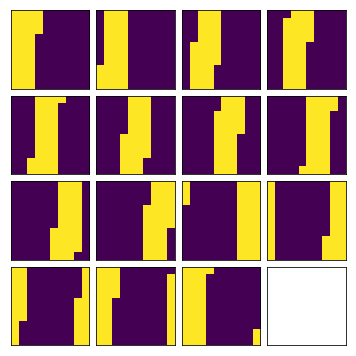

Execution time: at iteration 0 is 3.5181100368499756 seconds


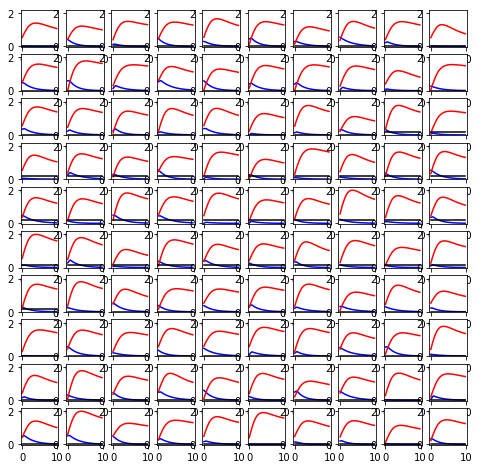

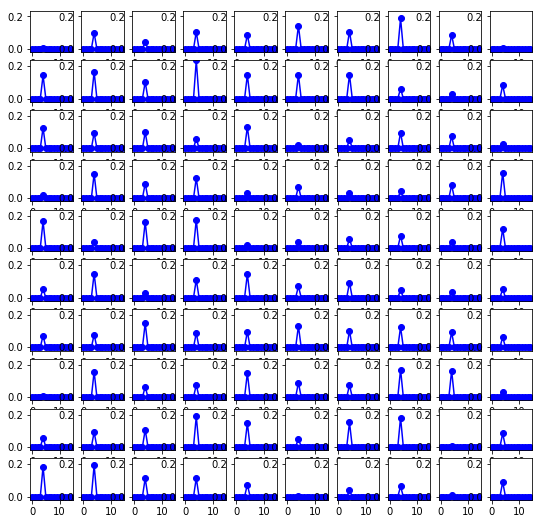

Presentation 1
Execution time: at iteration 1 is 3.4304308891296387 seconds
Execution time: at iteration 2 is 3.5389232635498047 seconds
Execution time: at iteration 3 is 3.4006357192993164 seconds
Execution time: at iteration 4 is 3.3065712451934814 seconds
Execution time: at iteration 5 is 3.2743585109710693 seconds
Execution time: at iteration 6 is 3.2859761714935303 seconds
Execution time: at iteration 7 is 3.303589105606079 seconds
Execution time: at iteration 8 is 3.2996842861175537 seconds
Execution time: at iteration 9 is 3.295789957046509 seconds
Execution time: at iteration 10 is 3.2786803245544434 seconds
Execution time: at iteration 11 is 3.2900633811950684 seconds
Execution time: at iteration 12 is 3.294501781463623 seconds
Execution time: at iteration 13 is 3.308335542678833 seconds
Execution time: at iteration 14 is 3.3310694694519043 seconds


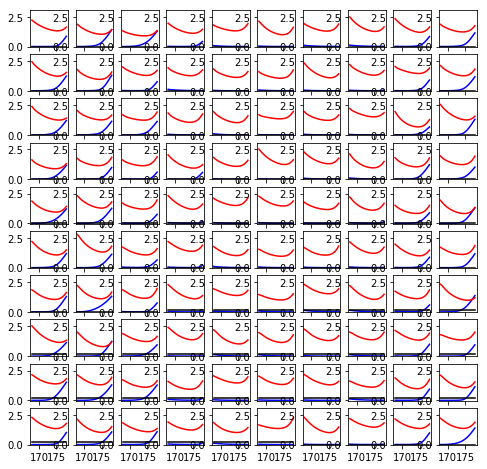

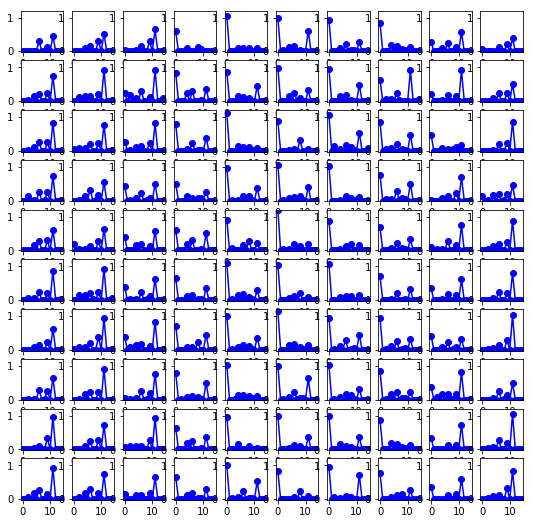

Presentation 15
Execution time: at iteration 15 is 3.468801498413086 seconds
Execution time: at iteration 16 is 3.546598196029663 seconds
Execution time: at iteration 17 is 3.3133113384246826 seconds
Execution time: at iteration 18 is 3.4955286979675293 seconds
Execution time: at iteration 19 is 3.5202808380126953 seconds
Execution time: at iteration 20 is 3.467172622680664 seconds
Execution time: at iteration 21 is 3.6900289058685303 seconds
Execution time: at iteration 22 is 3.3608646392822266 seconds
Execution time: at iteration 23 is 3.485292673110962 seconds
Execution time: at iteration 24 is 3.6536569595336914 seconds
Execution time: at iteration 25 is 3.4855575561523438 seconds
Execution time: at iteration 26 is 3.381805181503296 seconds
Execution time: at iteration 27 is 3.379218578338623 seconds
Execution time: at iteration 28 is 3.6230063438415527 seconds
Execution time: at iteration 29 is 3.789015054702759 seconds


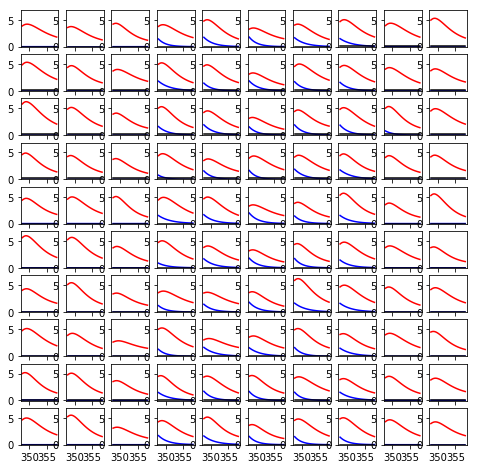

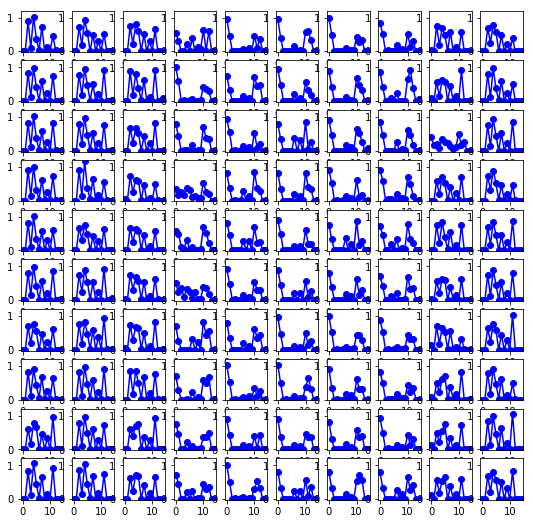

Presentation 30
Tue Dec  4 11:02:44 2018    restats

         159453198 function calls (157949542 primitive calls) in 135.552 seconds

   Ordered by: cumulative time
   List reduced from 1330 to 30 due to restriction <30>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
      2/1    0.000    0.000  135.565  135.565 {built-in method builtins.exec}
        1    0.000    0.000  135.565  135.565 <string>:1(<module>)
        1    0.090    0.090  135.564  135.564 <ipython-input-3-6df0af4caf37>:323(flat_run)
       60    0.179    0.003   96.210    1.604 /home/z/projects/draculab/network.py:1031(flat_run)
     1800    9.493    0.005   95.767    0.053 /home/z/projects/draculab/network.py:995(flat_update3)
   360000   24.339    0.000   31.247    0.000 /home/z/projects/draculab/units.py:996(upd_flat_inp_sum)
 21385800   19.457    0.000   24.907    0.000 /home/z/projects/draculab/synapses.py:536(update)
        6    0.000    0.000   15.840    2.640 /home/z/.local/lib/python

In [4]:
""" Running a simulation. """
# create a parameters object with the default values
p = parameters()
# Set any values specific to this simulation
p.N = 10 # number of units
p.md = 0.2 # minimum delay in the connections
p.t_pat = 10. # time a pattern is presented
p.t_trans = 2. # transition time between patterns
p.PE_lrate = 1./250. #learning rate of PE connections
p.PI_lrate = 1./250.
p.IE_mask = {'circular':{'radius':1.9}}
p.IE_kernel = {'gaussian' : {'p_center' : 1.2, 'sigma' : 2.}}
p.EI_mask = {'annular':{'inner_radius' : 1.5, 'outer_radius':2.7}}
p.EI_kernel = {'linear' : {'c' : 1.1, 'a' : 0.2}}
p.EE_mask = {'circular':{'radius':2.1}}
p.EE_kernel = {'gaussian' : {'p_center' : 1.2, 'sigma' : 1.5}}
p.EE__type = synapse_types.hebbsnorm 
p.EI_weights = {'uniform' : {'low' : 0.06, 'high' : 0.2}}
p.pat_type = 'snake'
# Initialize a simulation object with the specific parameters
sel = selection(p) 
# Create all the draculab objects and the input patterns
sel.build()
# Show the input patterns
sel.display_inputs()
# Run the simulation
n_pres = 30 # number of input patterns to present
n_disp = 2  # number of times outputs will be displayed

#sel.run(n_pres, n_disp)

# profiling run
import cProfile
import pstats

cProfile.run('sel.flat_run(n_pres, n_disp, 3)', 'restats')
prof = pstats.Stats('restats')
prof.sort_stats('cumulative').print_stats(30)
# 280.896 seconds


In [6]:
prof.sort_stats('tottime').print_stats(20)

Fri Nov 30 14:27:43 2018    restats

         159860853 function calls (158284242 primitive calls) in 115.730 seconds

   Ordered by: internal time
   List reduced from 3620 to 20 due to restriction <20>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
 21364200   18.866    0.000   24.129    0.000 /home/z/projects/draculab/synapses.py:536(update)
     6000   12.889    0.002   12.889    0.002 /home/z/projects/draculab/units.py:1098(set_function)
     1800    8.810    0.005   76.294    0.042 /home/z/projects/draculab/network.py:994(flat_update3)
 62659800    7.661    0.000    7.661    0.000 /home/z/projects/draculab/units.py:690(get_lpf_fast)
   360000    7.091    0.000    7.091    0.000 /home/z/projects/draculab/units.py:1053(ufis_4_numba)
1083600/541800    4.884    0.000    6.893    0.000 /home/z/.local/lib/python3.5/site-packages/numpy/core/numeric.py:1318(roll)
  4636800    4.256    0.000    5.350    0.000 /home/z/projects/draculab/synapses.py:419(update)
   3

In [ ]:
# Run using the third flattened network with numba experimental code
Fri Nov 30 14:27:43 2018    restats

         159860853 function calls (158284242 primitive calls) in 115.730 seconds

   Ordered by: cumulative time
   List reduced from 3620 to 30 due to restriction <30>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
     43/1    0.002    0.000  115.786  115.786 {built-in method builtins.exec}
        1    0.000    0.000  115.786  115.786 <string>:1(<module>)
        1    0.088    0.088  115.786  115.786 <ipython-input-3-6df0af4caf37>:323(flat_run)
       60    0.155    0.003   76.704    1.278 /home/z/projects/draculab/network.py:1030(flat_run)
     1800    8.810    0.005   76.294    0.042 /home/z/projects/draculab/network.py:994(flat_update3)
 21364200   18.866    0.000   24.129    0.000 /home/z/projects/draculab/synapses.py:536(update)
        6    0.000    0.000   15.429    2.571 /home/z/.local/lib/python3.5/site-packages/matplotlib/pyplot.py:236(show)
        6    0.000    0.000   15.429    2.571 /home/z/.local/lib/python3.5/site-packages/ipykernel/pylab/backend_inline.py:18(show)
        6    0.000    0.000   15.424    2.571 /home/z/.local/lib/python3.5/site-packages/IPython/core/display.py:129(display)
        6    0.000    0.000   15.413    2.569 /home/z/.local/lib/python3.5/site-packages/IPython/core/formatters.py:89(format)
       72    0.000    0.000   15.413    0.214 /home/z/.local/lib/python3.5/site-packages/IPython/core/formatters.py:220(catch_format_error)
       54    0.000    0.000   15.412    0.285 <decorator-gen-9>:1(__call__)
       54    0.000    0.000   15.412    0.285 /home/z/.local/lib/python3.5/site-packages/IPython/core/formatters.py:331(__call__)
        6    0.000    0.000   15.411    2.568 /home/z/.local/lib/python3.5/site-packages/IPython/core/pylabtools.py:241(<lambda>)
        6    0.005    0.001   15.411    2.568 /home/z/.local/lib/python3.5/site-packages/IPython/core/pylabtools.py:94(print_figure)
        6    0.023    0.004   15.405    2.568 /home/z/.local/lib/python3.5/site-packages/matplotlib/backend_bases.py:2107(print_figure)
        3    0.002    0.001   15.227    5.076 <ipython-input-3-6df0af4caf37>:209(plot_stuff)
   360000    0.821    0.000   14.158    0.000 /home/z/projects/draculab/units.py:994(upd_flat_inp_sum)
     6000   12.889    0.002   12.889    0.002 /home/z/projects/draculab/units.py:1098(set_function)
   540000    0.399    0.000   12.803    0.000 /home/z/projects/draculab/units.py:518(pre_syn_update)
       12    0.000    0.000   11.314    0.943 /home/z/.local/lib/python3.5/site-packages/matplotlib/backends/backend_agg.py:516(print_png)
       12    0.000    0.000   10.985    0.915 /home/z/.local/lib/python3.5/site-packages/matplotlib/backends/backend_agg.py:425(draw)
 39624/12    0.073    0.000   10.979    0.915 /home/z/.local/lib/python3.5/site-packages/matplotlib/artist.py:47(draw_wrapper)
       12    0.000    0.000   10.979    0.915 /home/z/.local/lib/python3.5/site-packages/matplotlib/figure.py:1456(draw)
  1212/12    0.010    0.000   10.975    0.915 /home/z/.local/lib/python3.5/site-packages/matplotlib/image.py:123(_draw_list_compositing_images)
     1200    0.012    0.000   10.970    0.009 /home/z/.local/lib/python3.5/site-packages/matplotlib/axes/_base.py:2556(draw)
18000/15600    0.217    0.000   10.719    0.001 /home/z/.local/lib/python3.5/site-packages/matplotlib/axis.py:74(__init__)
     2400    0.026    0.000   10.013    0.004 /home/z/.local/lib/python3.5/site-packages/matplotlib/axis.py:1182(draw)
     7200    0.147    0.000    9.479    0.001 /home/z/.local/lib/python3.5/site-packages/matplotlib/axis.py:1020(_update_ticks)
   540000    1.182    0.000    8.669    0.000 /home/z/projects/draculab/units.py:674(upd_lpf_fast)
#------------------------------------------------------------------------------------
# Run using the third flattened network
Thu Nov 29 15:22:43 2018    restats

         159702497 function calls (158198841 primitive calls) in 133.225 seconds

   Ordered by: cumulative time
   List reduced from 1330 to 30 due to restriction <30>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
      2/1    0.000    0.000  133.283  133.283 {built-in method builtins.exec}
        1    0.000    0.000  133.283  133.283 <string>:1(<module>)
        1    0.091    0.091  133.283  133.283 <ipython-input-3-6df0af4caf37>:323(flat_run)
       60    0.160    0.003   94.058    1.568 /home/z/projects/draculab/network.py:987(flat_run)
     1800    9.133    0.005   93.650    0.052 /home/z/projects/draculab/network.py:952(flat_update3)
   360000   24.420    0.000   30.324    0.000 /home/z/projects/draculab/units.py:840(upd_flat_inp_sum)
 21364200   19.016    0.000   24.119    0.000 /home/z/projects/draculab/synapses.py:536(update)
        3    0.002    0.001   15.216    5.072 <ipython-input-3-6df0af4caf37>:209(plot_stuff)
        6    0.000    0.000   14.765    2.461 /home/z/.local/lib/python3.5/site-packages/matplotlib/pyplot.py:236(show)
        6    0.000    0.000   14.765    2.461 /home/z/.local/lib/python3.5/site-packages/ipykernel/pylab/backend_inline.py:18(show)
        6    0.000    0.000   14.762    2.460 /home/z/.local/lib/python3.5/site-packages/IPython/core/display.py:129(display)
        6    0.000    0.000   14.751    2.459 /home/z/.local/lib/python3.5/site-packages/IPython/core/formatters.py:89(format)
       72    0.000    0.000   14.751    0.205 /home/z/.local/lib/python3.5/site-packages/IPython/core/formatters.py:220(catch_format_error)
       54    0.000    0.000   14.750    0.273 <decorator-gen-9>:1(__call__)
       54    0.000    0.000   14.750    0.273 /home/z/.local/lib/python3.5/site-packages/IPython/core/formatters.py:331(__call__)
        6    0.000    0.000   14.749    2.458 /home/z/.local/lib/python3.5/site-packages/IPython/core/pylabtools.py:241(<lambda>)
        6    0.005    0.001   14.749    2.458 /home/z/.local/lib/python3.5/site-packages/IPython/core/pylabtools.py:94(print_figure)
        6    0.022    0.004   14.744    2.457 /home/z/.local/lib/python3.5/site-packages/matplotlib/backend_bases.py:2107(print_figure)
     6000   13.193    0.002   13.193    0.002 /home/z/projects/draculab/units.py:899(set_function)
   540000    0.397    0.000   12.957    0.000 /home/z/projects/draculab/units.py:364(pre_syn_update)
18000/15600    0.227    0.000   10.871    0.001 /home/z/.local/lib/python3.5/site-packages/matplotlib/axis.py:74(__init__)
       12    0.000    0.000   10.663    0.889 /home/z/.local/lib/python3.5/site-packages/matplotlib/backends/backend_agg.py:516(print_png)
       12    0.000    0.000   10.329    0.861 /home/z/.local/lib/python3.5/site-packages/matplotlib/backends/backend_agg.py:425(draw)
 39624/12    0.075    0.000   10.323    0.860 /home/z/.local/lib/python3.5/site-packages/matplotlib/artist.py:47(draw_wrapper)
       12    0.000    0.000   10.323    0.860 /home/z/.local/lib/python3.5/site-packages/matplotlib/figure.py:1456(draw)
  1212/12    0.011    0.000   10.319    0.860 /home/z/.local/lib/python3.5/site-packages/matplotlib/image.py:123(_draw_list_compositing_images)
     1200    0.012    0.000   10.315    0.009 /home/z/.local/lib/python3.5/site-packages/matplotlib/axes/_base.py:2556(draw)
     2400    0.026    0.000    9.364    0.004 /home/z/.local/lib/python3.5/site-packages/matplotlib/axis.py:1182(draw)
     7200    0.146    0.000    8.828    0.001 /home/z/.local/lib/python3.5/site-packages/matplotlib/axis.py:1020(_update_ticks)
      900    0.033    0.000    8.658    0.010 /home/z/.local/lib/python3.5/site-packages/matplotlib/axes/_base.py:1000(cla)

#----------------------------------------------------------------------------------------------------
# Run using the second flattened network after debugging
Thu Nov 29 11:44:28 2018    restats

         158992297 function calls (157500647 primitive calls) in 132.869 seconds

   Ordered by: cumulative time
   List reduced from 1327 to 30 due to restriction <30>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
      2/1    0.000    0.000  132.928  132.928 {built-in method builtins.exec}
        1    0.000    0.000  132.928  132.928 <string>:1(<module>)
        1    0.088    0.088  132.927  132.927 <ipython-input-3-6df0af4caf37>:323(flat_run)
       60    0.157    0.003   94.188    1.570 /home/z/projects/draculab/network.py:983(flat_run)
     1800   34.707    0.019   93.800    0.052 /home/z/projects/draculab/network.py:905(flat_update2)
 21492000   18.996    0.000   24.266    0.000 /home/z/projects/draculab/synapses.py:536(update)
        3    0.002    0.001   15.003    5.001 <ipython-input-3-6df0af4caf37>:209(plot_stuff)
        6    0.000    0.000   14.562    2.427 /home/z/.local/lib/python3.5/site-packages/matplotlib/pyplot.py:236(show)
        6    0.000    0.000   14.562    2.427 /home/z/.local/lib/python3.5/site-packages/ipykernel/pylab/backend_inline.py:18(show)
        6    0.000    0.000   14.559    2.426 /home/z/.local/lib/python3.5/site-packages/IPython/core/display.py:129(display)
        6    0.000    0.000   14.549    2.425 /home/z/.local/lib/python3.5/site-packages/IPython/core/formatters.py:89(format)
       72    0.000    0.000   14.548    0.202 /home/z/.local/lib/python3.5/site-packages/IPython/core/formatters.py:220(catch_format_error)
       54    0.000    0.000   14.547    0.269 <decorator-gen-9>:1(__call__)
       54    0.000    0.000   14.547    0.269 /home/z/.local/lib/python3.5/site-packages/IPython/core/formatters.py:331(__call__)
        6    0.000    0.000   14.546    2.424 /home/z/.local/lib/python3.5/site-packages/IPython/core/pylabtools.py:241(<lambda>)
        6    0.005    0.001   14.546    2.424 /home/z/.local/lib/python3.5/site-packages/IPython/core/pylabtools.py:94(print_figure)
        6    0.022    0.004   14.541    2.423 /home/z/.local/lib/python3.5/site-packages/matplotlib/backend_bases.py:2107(print_figure)
   540000    0.420    0.000   13.333    0.000 /home/z/projects/draculab/units.py:364(pre_syn_update)
     6000   13.036    0.002   13.036    0.002 /home/z/projects/draculab/units.py:897(set_function)
18000/15600    0.216    0.000   10.627    0.001 /home/z/.local/lib/python3.5/site-packages/matplotlib/axis.py:74(__init__)
       12    0.000    0.000   10.542    0.878 /home/z/.local/lib/python3.5/site-packages/matplotlib/backends/backend_agg.py:516(print_png)
       12    0.000    0.000   10.208    0.851 /home/z/.local/lib/python3.5/site-packages/matplotlib/backends/backend_agg.py:425(draw)
 39624/12    0.075    0.000   10.202    0.850 /home/z/.local/lib/python3.5/site-packages/matplotlib/artist.py:47(draw_wrapper)
       12    0.000    0.000   10.201    0.850 /home/z/.local/lib/python3.5/site-packages/matplotlib/figure.py:1456(draw)
  1212/12    0.010    0.000   10.197    0.850 /home/z/.local/lib/python3.5/site-packages/matplotlib/image.py:123(_draw_list_compositing_images)
     1200    0.012    0.000   10.193    0.008 /home/z/.local/lib/python3.5/site-packages/matplotlib/axes/_base.py:2556(draw)
     2400    0.027    0.000    9.241    0.004 /home/z/.local/lib/python3.5/site-packages/matplotlib/axis.py:1182(draw)
   540000    1.202    0.000    8.947    0.000 /home/z/projects/draculab/units.py:520(upd_lpf_fast)
     7200    0.146    0.000    8.693    0.001 /home/z/.local/lib/python3.5/site-packages/matplotlib/axis.py:1020(_update_ticks)
      900    0.033    0.000    8.626    0.010 /home/z/.local/lib/python3.5/site-packages/matplotlib/axes/_base.py:1000(cla)


--------------------------------------------------------------------------
# Run on mac using the first corrected flattened network for 10 presentations
Thu Nov 22 22:10:48 2018    restats

         207075078 function calls (205352172 primitive calls) in 195.405 seconds

   Ordered by: cumulative time
   List reduced from 1245 to 30 due to restriction <30>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000  195.421  195.421 {built-in method builtins.exec}
        1    0.000    0.000  195.421  195.421 <string>:1(<module>)
        1    0.132    0.132  195.421  195.421 <ipython-input-3-a2523db7d8de>:323(flat_run)
       20    0.091    0.005  123.941    6.197 /Users/sergio/projects/draculab/network.py:883(flat_run)
      600    6.605    0.011  123.658    0.206 /Users/sergio/projects/draculab/network.py:810(test_update)
      600    5.404    0.009   80.181    0.134 /Users/sergio/projects/draculab/network.py:775(upd_inp_sums)
   600000   27.428    0.000   68.298    0.000 /Users/sergio/projects/draculab/network.py:790(<listcomp>)
        6    0.000    0.000   46.142    7.690 /usr/local/lib/python3.7/site-packages/matplotlib/pyplot.py:237(show)
        6    0.000    0.000   46.142    7.690 /usr/local/lib/python3.7/site-packages/ipykernel/pylab/backend_inline.py:19(show)
        6    0.000    0.000   42.099    7.017 /usr/local/lib/python3.7/site-packages/IPython/core/display.py:129(display)
        6    0.000    0.000   42.089    7.015 /usr/local/lib/python3.7/site-packages/IPython/core/formatters.py:89(format)
       72    0.000    0.000   42.089    0.585 /usr/local/lib/python3.7/site-packages/IPython/core/formatters.py:220(catch_format_error)
       54    0.000    0.000   42.088    0.779 <decorator-gen-9>:1(__call__)
       54    0.000    0.000   42.088    0.779 /usr/local/lib/python3.7/site-packages/IPython/core/formatters.py:331(__call__)
        6    0.000    0.000   42.086    7.014 /usr/local/lib/python3.7/site-packages/IPython/core/pylabtools.py:244(<lambda>)
        6    0.000    0.000   42.086    7.014 /usr/local/lib/python3.7/site-packages/IPython/core/pylabtools.py:97(print_figure)
        6    0.010    0.002   42.086    7.014 /usr/local/lib/python3.7/site-packages/matplotlib/backend_bases.py:1950(print_figure)
 65694000   28.202    0.000   40.985    0.000 /Users/sergio/projects/draculab/network.py:762(get_act_by_step)
        3    0.003    0.001   35.601   11.867 <ipython-input-3-a2523db7d8de>:209(plot_stuff)
        6    0.047    0.008   26.958    4.493 /usr/local/lib/python3.7/site-packages/matplotlib/figure.py:2239(get_tightbbox)
28800/26400    0.498    0.000   25.935    0.001 /usr/local/lib/python3.7/site-packages/matplotlib/axis.py:72(__init__)
    16800    0.496    0.000   25.731    0.002 /usr/local/lib/python3.7/site-packages/matplotlib/axis.py:1015(_update_ticks)
     6000    0.193    0.000   23.352    0.004 /usr/local/lib/python3.7/site-packages/matplotlib/axis.py:1132(get_tightbbox)
     1200    0.135    0.000   21.310    0.018 /usr/local/lib/python3.7/site-packages/matplotlib/axes/_base.py:4328(get_tightbbox)
    84000    0.227    0.000   20.809    0.000 /usr/local/lib/python3.7/site-packages/matplotlib/axis.py:963(iter_ticks)
    18000    0.072    0.000   18.656    0.001 /usr/local/lib/python3.7/site-packages/matplotlib/ticker.py:1983(__call__)
    18000    0.080    0.000   18.547    0.001 /usr/local/lib/python3.7/site-packages/matplotlib/ticker.py:1987(tick_values)
    18000    1.048    0.000   18.214    0.001 /usr/local/lib/python3.7/site-packages/matplotlib/ticker.py:1923(_raw_ticks)
  7168800   13.052    0.000   16.124    0.000 /Users/sergio/projects/draculab/synapses.py:536(update)
       12    0.000    0.000   14.784    1.232 /usr/local/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:468(print_png)

---------------------------------------------------------------------
# Run using the corrected flattened network:
Wed Nov 21 16:38:44 2018    restats

         470995448 function calls (469131792 primitive calls) in 239.018 seconds

   Ordered by: cumulative time
   List reduced from 1323 to 30 due to restriction <30>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
      2/1    0.000    0.000  239.031  239.031 {built-in method builtins.exec}
        1    0.000    0.000  239.031  239.031 <string>:1(<module>)
        1    0.091    0.091  239.031  239.031 <ipython-input-3-272715de06e9>:323(flat_run)
       60    0.167    0.003  199.894    3.332 /home/z/projects/draculab/network.py:809(flat_run)
     1800   10.573    0.006  199.524    0.111 /home/z/projects/draculab/network.py:781(test_update)
     1800    2.240    0.001  128.753    0.072 /home/z/projects/draculab/network.py:753(upd_inp_sums)
  1800000   48.625    0.000  119.585    0.000 /home/z/projects/draculab/network.py:759(<listcomp>)
197505000   50.282    0.000   71.147    0.000 /home/z/projects/draculab/network.py:741(get_act_by_step)
 21544200   19.818    0.000   25.909    0.000 /home/z/projects/draculab/synapses.py:536(update)
        3    0.002    0.001   15.158    5.053 <ipython-input-3-272715de06e9>:209(plot_stuff)
        6    0.000    0.000   14.536    2.423 /home/z/.local/lib/python3.5/site-packages/matplotlib/pyplot.py:236(show)
        6    0.000    0.000   14.536    2.423 /home/z/.local/lib/python3.5/site-packages/ipykernel/pylab/backend_inline.py:18(show)
        6    0.000    0.000   14.533    2.422 /home/z/.local/lib/python3.5/site-packages/IPython/core/display.py:129(display)
        6    0.000    0.000   14.523    2.420 /home/z/.local/lib/python3.5/site-packages/IPython/core/formatters.py:89(format)
       72    0.000    0.000   14.523    0.202 /home/z/.local/lib/python3.5/site-packages/IPython/core/formatters.py:220(catch_format_error)
       54    0.000    0.000   14.522    0.269 <decorator-gen-9>:1(__call__)
       54    0.000    0.000   14.522    0.269 /home/z/.local/lib/python3.5/site-packages/IPython/core/formatters.py:331(__call__)
        6    0.000    0.000   14.521    2.420 /home/z/.local/lib/python3.5/site-packages/IPython/core/pylabtools.py:241(<lambda>)
        6    0.005    0.001   14.521    2.420 /home/z/.local/lib/python3.5/site-packages/IPython/core/pylabtools.py:94(print_figure)
        6    0.023    0.004   14.515    2.419 /home/z/.local/lib/python3.5/site-packages/matplotlib/backend_bases.py:2107(print_figure)
   540000    0.424    0.000   13.405    0.000 /home/z/projects/draculab/units.py:361(pre_syn_update)
     6000   13.237    0.002   13.237    0.002 /home/z/projects/draculab/units.py:870(set_function)
 90067500   12.670    0.000   12.670    0.000 <ipython-input-3-272715de06e9>:225(<lambda>)
1803600/901800    8.127    0.000   11.436    0.000 /home/z/.local/lib/python3.5/site-packages/numpy/core/numeric.py:1318(roll)
       12    0.000    0.000   10.438    0.870 /home/z/.local/lib/python3.5/site-packages/matplotlib/backends/backend_agg.py:516(print_png)
       12    0.000    0.000   10.113    0.843 /home/z/.local/lib/python3.5/site-packages/matplotlib/backends/backend_agg.py:425(draw)
 39624/12    0.074    0.000   10.107    0.842 /home/z/.local/lib/python3.5/site-packages/matplotlib/artist.py:47(draw_wrapper)
       12    0.000    0.000   10.107    0.842 /home/z/.local/lib/python3.5/site-packages/matplotlib/figure.py:1456(draw)
  1212/12    0.011    0.000   10.103    0.842 /home/z/.local/lib/python3.5/site-packages/matplotlib/image.py:123(_draw_list_compositing_images)
     1200    0.012    0.000   10.098    0.008 /home/z/.local/lib/python3.5/site-packages/matplotlib/axes/_base.py:2556(draw)
            
-----------------------------------------------------------------------------------------------------------------
Ran using forward Euler:
Tue Nov 20 15:49:21 2018    restats

         458167952 function calls (455958102 primitive calls) in 270.110 seconds

   Ordered by: cumulative time
   List reduced from 1314 to 30 due to restriction <30>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
      2/1    0.000    0.000  270.111  270.111 {built-in method builtins.exec}
        1    0.000    0.000  270.111  270.111 <string>:1(<module>)
        1    0.088    0.088  270.111  270.111 <ipython-input-3-272715de06e9>:234(run)
       60    0.483    0.008  231.301    3.855 /home/z/projects/draculab/network.py:818(run)
   360000    9.168    0.000  227.920    0.001 /home/z/projects/draculab/units.py:224(update)
   360000    2.614    0.000  158.371    0.000 {cython_utils.euler_int}
  1800000    1.485    0.000  155.757    0.000 /home/z/projects/draculab/custom_units.py:53(derivatives)
  1800000    2.817    0.000  148.545    0.000 /home/z/projects/draculab/units.py:147(get_input_sum)
  1800000   59.438    0.000  138.601    0.000 /home/z/projects/draculab/units.py:154(<listcomp>)
 90216000   24.524    0.000   59.927    0.000 /home/z/projects/draculab/units.py:307(get_act)
 90216000   35.403    0.000   35.403    0.000 {cython_utils.cython_get_act3}
 21234600   19.199    0.000   24.850    0.000 /home/z/projects/draculab/synapses.py:536(update)
2520000/1260000   15.708    0.000   21.081    0.000 /home/z/.local/lib/python3.5/site-packages/numpy/core/numeric.py:1318(roll)
        3    0.002    0.001   15.293    5.098 <ipython-input-3-272715de06e9>:209(plot_stuff)
        6    0.000    0.000   14.613    2.436 /home/z/.local/lib/python3.5/site-packages/matplotlib/pyplot.py:236(show)
        6    0.000    0.000   14.613    2.436 /home/z/.local/lib/python3.5/site-packages/ipykernel/pylab/backend_inline.py:18(show)
        6    0.000    0.000   14.610    2.435 /home/z/.local/lib/python3.5/site-packages/IPython/core/display.py:129(display)
        6    0.000    0.000   14.601    2.433 /home/z/.local/lib/python3.5/site-packages/IPython/core/formatters.py:89(format)
       72    0.000    0.000   14.600    0.203 /home/z/.local/lib/python3.5/site-packages/IPython/core/formatters.py:220(catch_format_error)
       54    0.000    0.000   14.599    0.270 <decorator-gen-9>:1(__call__)
       54    0.000    0.000   14.599    0.270 /home/z/.local/lib/python3.5/site-packages/IPython/core/formatters.py:331(__call__)
        6    0.000    0.000   14.598    2.433 /home/z/.local/lib/python3.5/site-packages/IPython/core/pylabtools.py:241(<lambda>)
        6    0.005    0.001   14.598    2.433 /home/z/.local/lib/python3.5/site-packages/IPython/core/pylabtools.py:94(print_figure)
        6    0.023    0.004   14.592    2.432 /home/z/.local/lib/python3.5/site-packages/matplotlib/backend_bases.py:2107(print_figure)
   540000    0.482    0.000   13.642    0.000 /home/z/projects/draculab/units.py:358(pre_syn_update)
     6000   12.663    0.002   12.663    0.002 /home/z/projects/draculab/units.py:867(set_function)
18000/15600    0.227    0.000   10.845    0.001 /home/z/.local/lib/python3.5/site-packages/matplotlib/axis.py:74(__init__)
 88777500   10.491    0.000   10.491    0.000 <ipython-input-3-272715de06e9>:225(<lambda>)
       12    0.000    0.000   10.477    0.873 /home/z/.local/lib/python3.5/site-packages/matplotlib/backends/backend_agg.py:516(print_png)
       12    0.000    0.000   10.149    0.846 /home/z/.local/lib/python3.5/site-packages/matplotlib/backends/backend_agg.py:425(draw)

In [96]:
import numpy.ma as ma
y = ma.array([[1,2,3,4],[5,6,7,8],[9,10,11,12]], mask=[[1,0,0,0],[1,1,0,0],[0,0,0,0]], hard_mask=True)
print(y)
#np.roll(y[0,1:],-1)
idx = [[0,0],[1,1],[2,2]], [[1,2],[2,3],[0,1]]
v = y[ idx ].data
y[0,2] = 18
print(y)
print(v)

[[-- 2 3 4]
 [-- -- 7 8]
 [9 10 11 12]]
[[-- 2 18 4]
 [-- -- 7 8]
 [9 10 11 12]]
[[ 2  3]
 [ 7  8]
 [ 9 10]]


In [74]:
y = np.arange(35).reshape(5,7)
print(y)
#y[np.array([0,2,4]), np.array([0,1,2])]
#y[[0,1]][((0,0,1,1),(0,1,4,5))].reshape(2,2)
y[ [[0,0],[1,1]],[[1,2],[5,6]] ] 

[[ 0  1  2  3  4  5  6]
 [ 7  8  9 10 11 12 13]
 [14 15 16 17 18 19 20]
 [21 22 23 24 25 26 27]
 [28 29 30 31 32 33 34]]


array([[ 1,  2],
       [12, 13]])

In [86]:
z = np.arange(12).reshape(3,4)
print(z)
m = np.array([[False, True, True, False],[False, False, True, True],[False, False, True, True]])
z[m]

[[ 0  1  2  3]
 [ 4  5  6  7]
 [ 8  9 10 11]]


array([ 1,  2,  6,  7, 10, 11])

## Interesting parameter changes
With:

`p.N = 8 # number of units
p.md = 0.2 # minimum delay in the connections
p.t_pat = 10. # time a pattern is presented
p.t_trans = 2. # transition time between patterns
p.PE_lrate = 1./250. #learning rate of PE connections
p.PI_lrate = 1./250.`
You can get, if
* `p.pat_type = 'lines'`, pretty decent selectivity that can be observed in the weight grid.
* `p.pat_type = 'snake'`, a rather homogeneous response with giant inhibitions up to presentation 80.
* `p.pat_type = 'random'`, responses become very homogeneous in here too.

Homogeneity may dissapear when lateral competition is dominant. Say:

`p.N = 10 # number of units
p.md = 0.2 # minimum delay in the connections
p.t_pat = 10. # time a pattern is presented
p.t_trans = 2. # transition time between patterns
p.PE_lrate = 1./250. #learning rate of PE connections
p.PI_lrate = 1./250.
p.IE_mask = {'circular':{'radius':1.9}}
p.IE_kernel = {'gaussian' : {'p_center' : 1.2, 'sigma' : 2.}}
p.EI_mask = {'annular':{'inner_radius' : 1.5, 'outer_radius':2.7}}
p.EI_kernel = {'linear' : {'c' : 1.1, 'a' : 0.2}}
p.EE_mask = {'circular':{'radius':2.1}}
p.EE_kernel = {'gaussian' : {'p_center' : 1.2, 'sigma' : 1.5}}
p.EI_weights = {'uniform' : {'low' : 0.06, 'high' : 0.2}}
p.pat_type = 'snake'`

With this the units break down into two groups. Units in the same group have a similar response profile. Changing `p.N = 12` creates 3 groups instead of two. It seems the number of groups is related to the diameter of the Mexican hat in relation to the network.
To test this, I set `p.pat_type = 'random'`, and manually changed the code in selection.build() so only 3 different input patterns would be generated. Along 100 pattern presentations there were points where the population seemed to be dividing into 3 groups, each preferring one of the 3 patterns. At the end, however, 

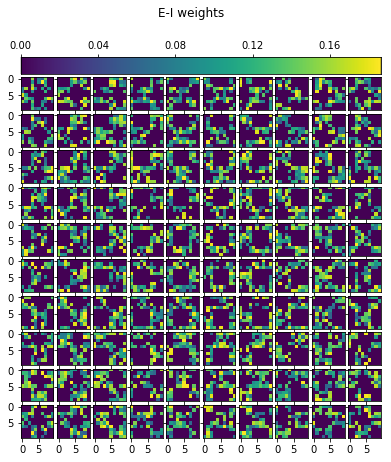

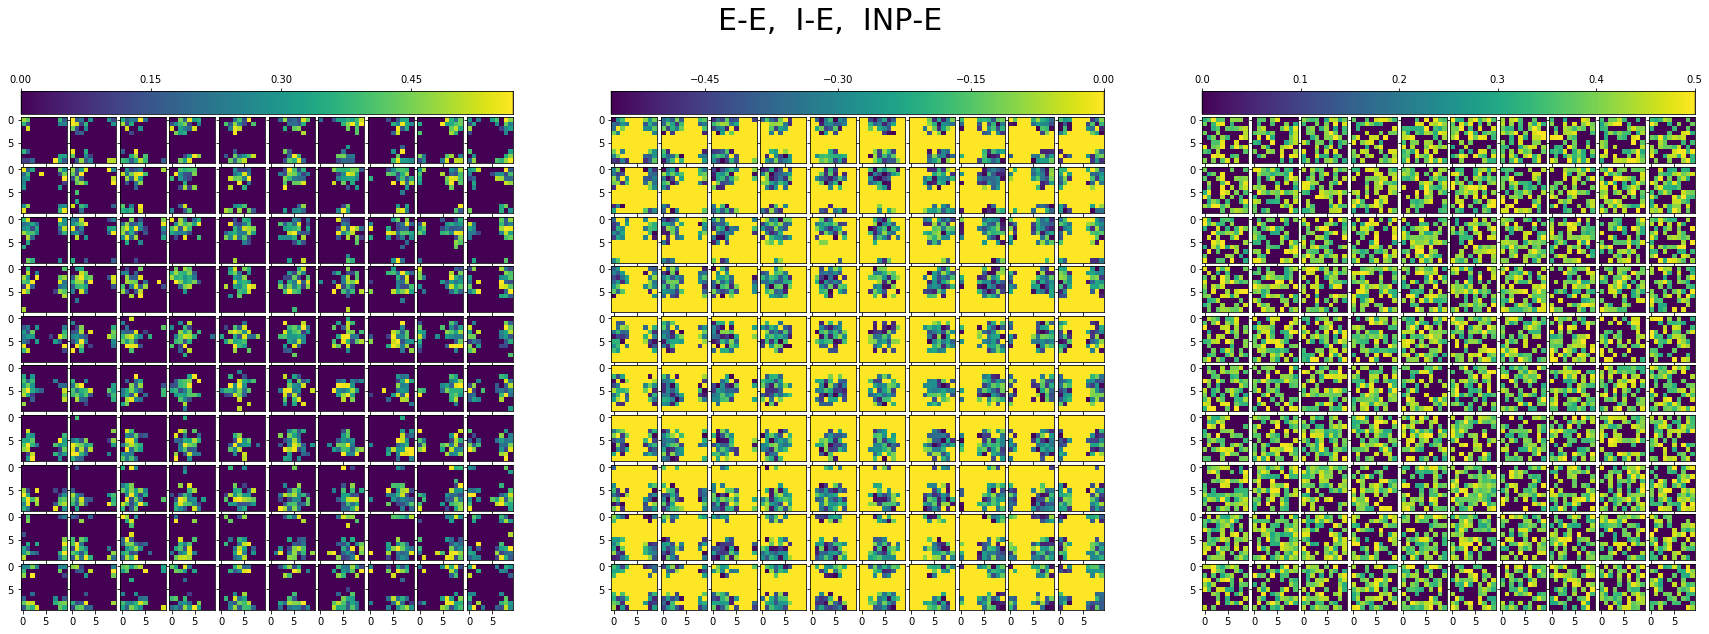

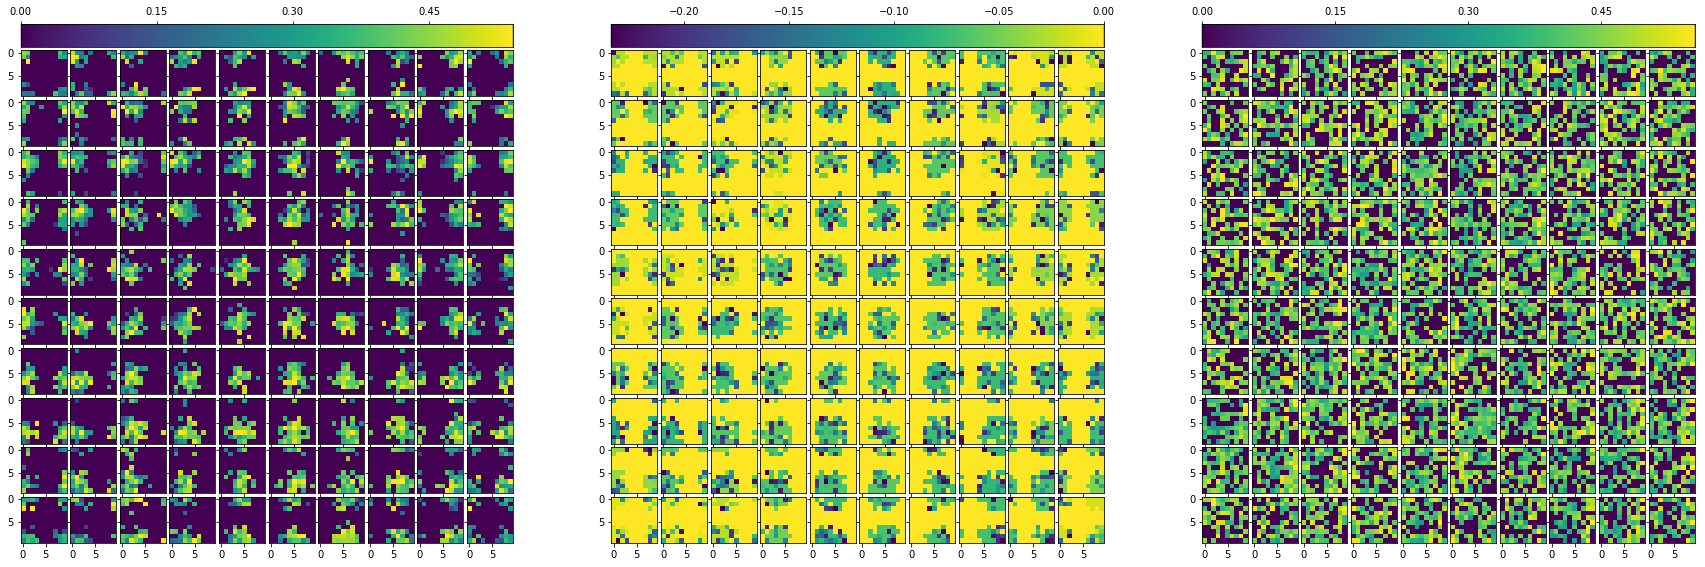

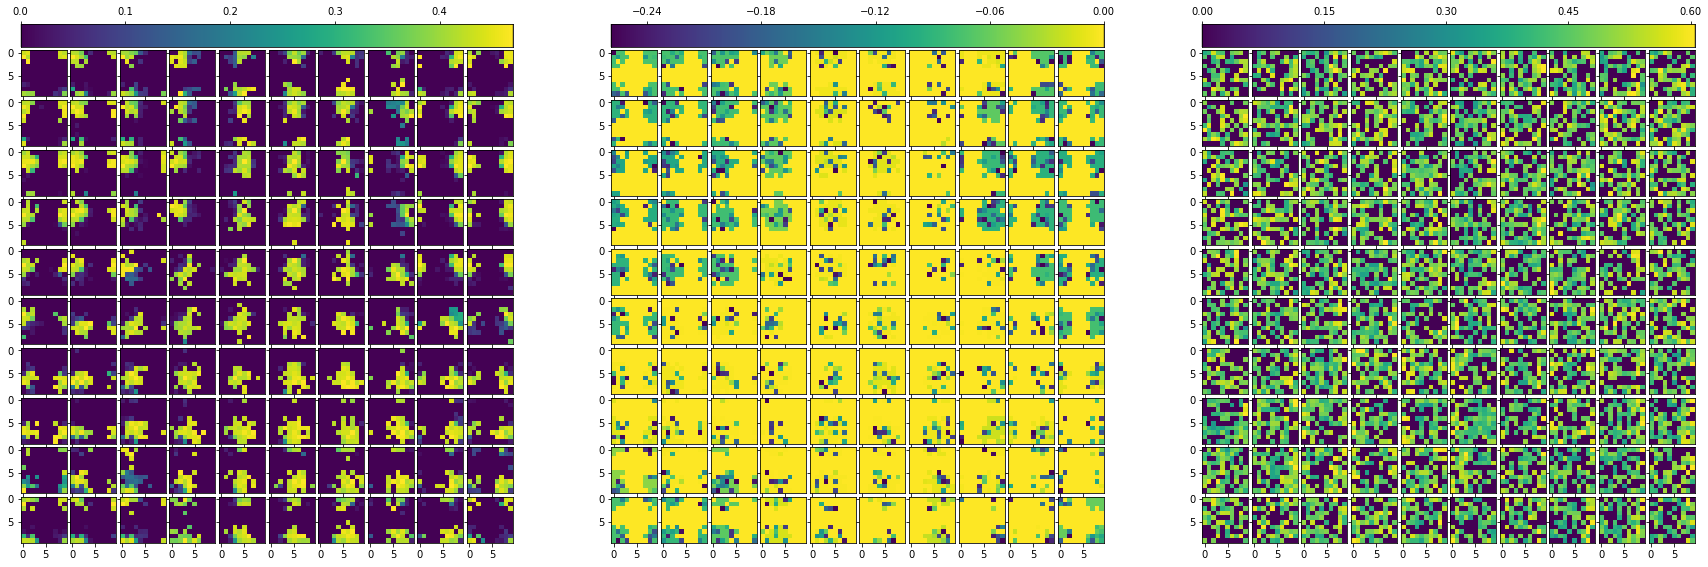

Excitatory squared sums:	[2.2280104647961436, 2.3753003928121665, 2.4973760003729497]
Inhibitory sums:	[-10.873530651060197, -1.8086548475646334, -3.848588744766352]
External input sums: 	[21.805253831329818, 23.460910275013028, 24.99725591878905]


In [5]:
sel.view_weight_grid()

/home/z/.local/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


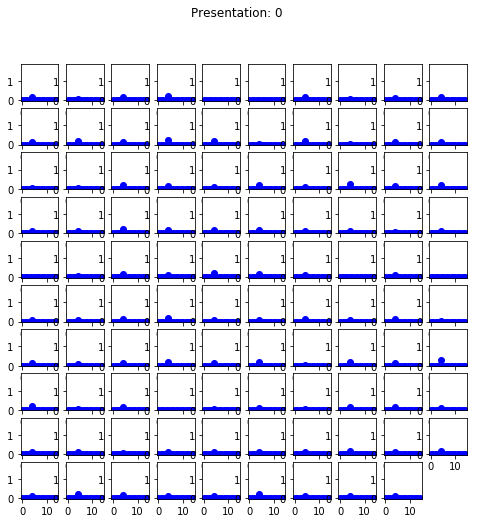

In [6]:
from matplotlib.animation import FuncAnimation
#%matplotlib notebook
%matplotlib qt5
ani = sel.animate_responses(50)
#plt.show()

Execution time: at iteration 0 is 8.043429136276245 seconds


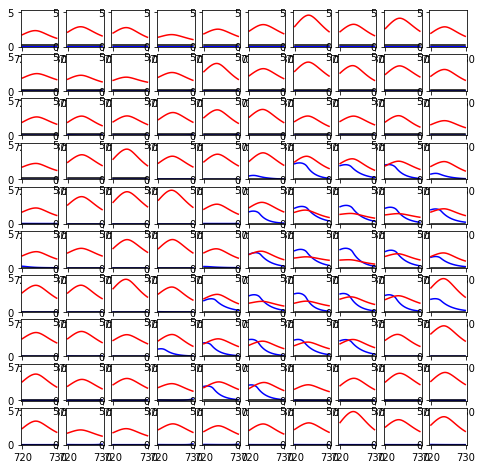

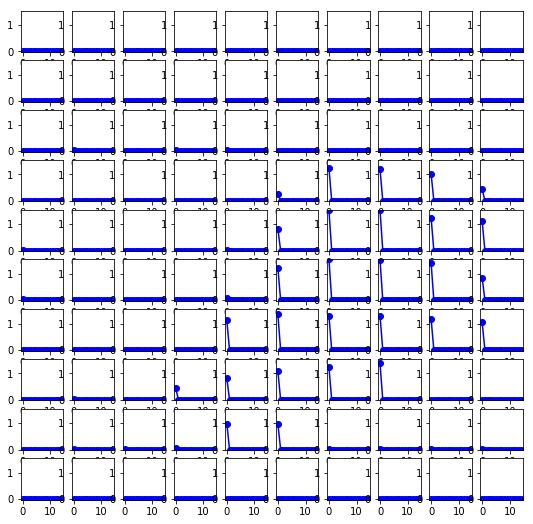

Presentation 1
Execution time: at iteration 1 is 8.056318759918213 seconds
Execution time: at iteration 2 is 7.914753198623657 seconds
Execution time: at iteration 3 is 7.90579080581665 seconds
Execution time: at iteration 4 is 8.233118534088135 seconds
Execution time: at iteration 5 is 7.97826361656189 seconds
Execution time: at iteration 6 is 7.9246134757995605 seconds
Execution time: at iteration 7 is 8.1322021484375 seconds
Execution time: at iteration 8 is 7.954434871673584 seconds
Execution time: at iteration 9 is 7.86337947845459 seconds
Execution time: at iteration 10 is 8.322763681411743 seconds
Execution time: at iteration 11 is 8.138489484786987 seconds
Execution time: at iteration 12 is 7.900775194168091 seconds
Execution time: at iteration 13 is 8.091675996780396 seconds
Execution time: at iteration 14 is 8.199953317642212 seconds
Execution time: at iteration 15 is 7.863433599472046 seconds
Execution time: at iteration 16 is 8.419836044311523 seconds
Execution time: at ite

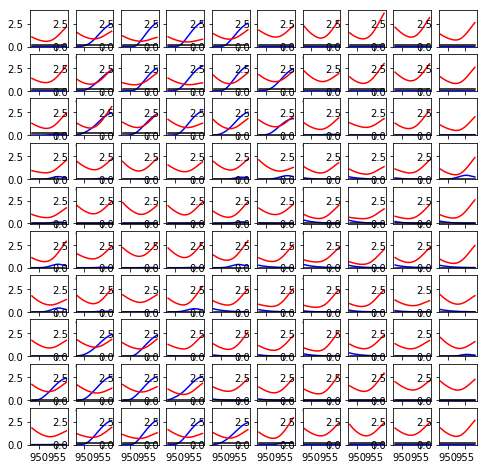

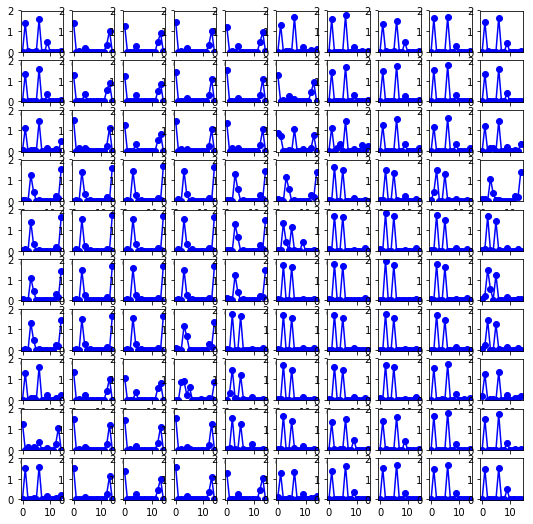

Presentation 20
Execution time: at iteration 20 is 8.200409889221191 seconds
Execution time: at iteration 21 is 8.21030306816101 seconds
Execution time: at iteration 22 is 8.581881046295166 seconds
Execution time: at iteration 23 is 8.276987075805664 seconds
Execution time: at iteration 24 is 8.654115200042725 seconds
Execution time: at iteration 25 is 8.662931442260742 seconds
Execution time: at iteration 26 is 8.530964851379395 seconds
Execution time: at iteration 27 is 9.226472616195679 seconds
Execution time: at iteration 28 is 7.958832263946533 seconds
Execution time: at iteration 29 is 9.285593271255493 seconds
Execution time: at iteration 30 is 8.718335628509521 seconds
Execution time: at iteration 31 is 8.773857831954956 seconds
Execution time: at iteration 32 is 8.871247291564941 seconds
Execution time: at iteration 33 is 8.30839490890503 seconds
Execution time: at iteration 34 is 8.975102424621582 seconds
Execution time: at iteration 35 is 8.782536745071411 seconds
Execution 

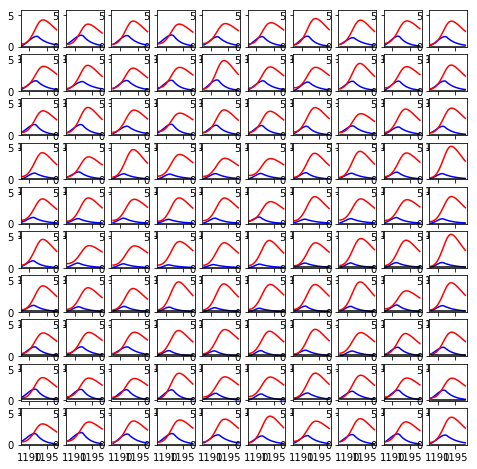

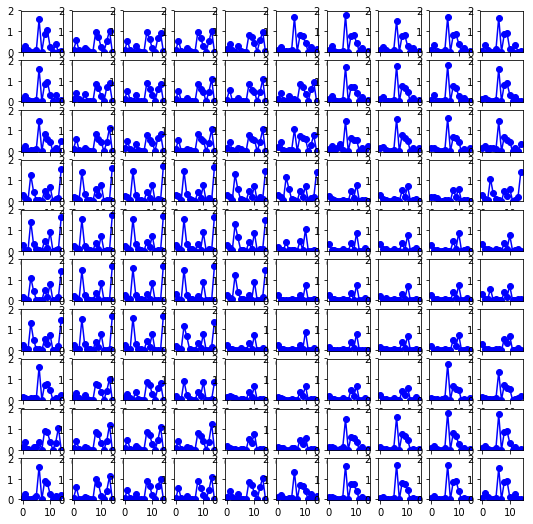

Presentation 40


In [8]:
""" Want to continue? """
# Run the simulation
n_pres = 40 # number of inputpatterns to present
n_disp = 2  # number of times outputs will be displayed
sel.run(n_pres, n_disp)

The point of these simulations is to find whether the E-I network with the type of plasticity from Moldakarinov06 is suited for becoming a network where each unit selects a particular subset of the descending inputs.

Due to the topological arrangement of the connections, it is reasonable to assume that spatially structured inputs, such as the "progressive lines" will have patterns that target some units slightly more than others. The point is for the network to pick on those slight preferences and to enhance them using the lateral connections as exta constraints.

In the case of the progressive lines we can: 
* find a 'center' for each pattern, as the average of the coordinates for each unit that is on when the pattern is present. That's the 'centers' vector obtained above.
* for each excitatory unit, measure its average activity level for each pattern. 
* plot what is the correlation between the distance to a pattern VS the activity level when the pattern is presented.
  This can be done in first vs last iterations.

This figure shows that units become very selective to particular patterns, and the number of units devoted to each pattern is evenly distributed. It is not quite how I imagined it, but it couldn't be better.

In [9]:
p = np.array([[1,2],[3,4]])
print(p.shape)
p.reshape(4,order='F')

(2, 2)


array([1, 3, 2, 4])